## BIKE RENTING

Bike sharing systems are a means of renting bicycles where the process of
obtaining membership, rental, and bike return is automated via a network of
kiosk locations throughout a city. Using these systems, people are able to
rent a bike from one location and return it to a different place on an
as-needed basis. Currently, there are over 500 bike-sharing programs
around the world.

The data generated by these systems makes them attractive for
researchers because the duration of travel, departure location, arrival
location, and time elapsed is explicitly recorded. Bike sharing systems
therefore function as a sensor network, which can be used for studying
mobility in a city.

In this project, I am asked to combine historical usage patterns with
weather data in order to forecast hourly bike rental demand.



--<<got data set from kaggle.com>>--

In [38]:
# importing libraries
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import calendar
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [39]:
# loadind the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [40]:
# shape of training and testing data
train.shape, test.shape

((12980, 12), (4399, 11))

There are 12 columns in train dataset, whereas 11 in the test dataset. The missing column in the test dataset is the target variable and I will train our model to predict that variable.

In [41]:
# printing first five rows
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


In [42]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
0,2012-06-30 1:00:00,3,0,0,3,26.24,28.790,89.0,15.0013,3,55
1,2012-06-30 2:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,7,54
2,2012-06-30 3:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,3,20
3,2012-06-30 4:00:00,3,0,0,2,25.42,27.275,94.0,0.0000,3,15
4,2012-06-30 5:00:00,3,0,0,1,26.24,28.790,89.0,11.0014,3,7


In [43]:
# columns in the dataset
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [44]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered'],
      dtype='object')

In [45]:
# Data type of the columns
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

I can infer that all of the variable in the dataset except datetime are numerical variables. Now Let's look at the distribution of our target variable, i.e. count. As it is a numerical variable, let us look at its distribution.

## Univariate Analysis

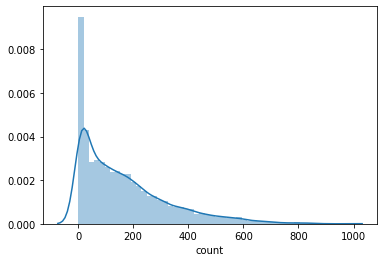

In [46]:
# distribution of count variable
sn.distplot(train["count"])

The distribution is skewed towards right and hence we can take log of the variable and see if the distribution becomes normal.

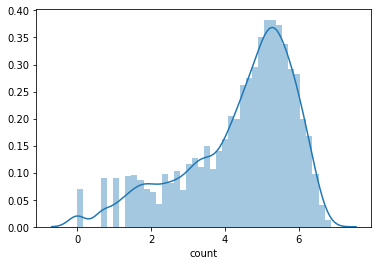

In [47]:
sn.distplot(np.log(train["count"]))

The distribution looks less skewed. Now I will explore the variables to have a better understanding of the dataset. I will first explore the variables individually using univariate analysis, then I will look at the relation between various independent variables and the target variable. I will also look at the correlation plot to see which variables affects the target variable most.


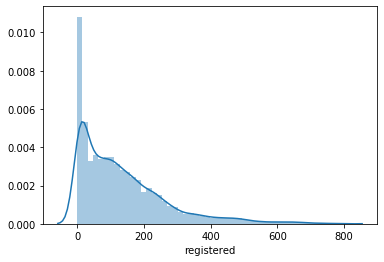

In [48]:
sn.distplot(train["registered"])

## Bivariate Analysis

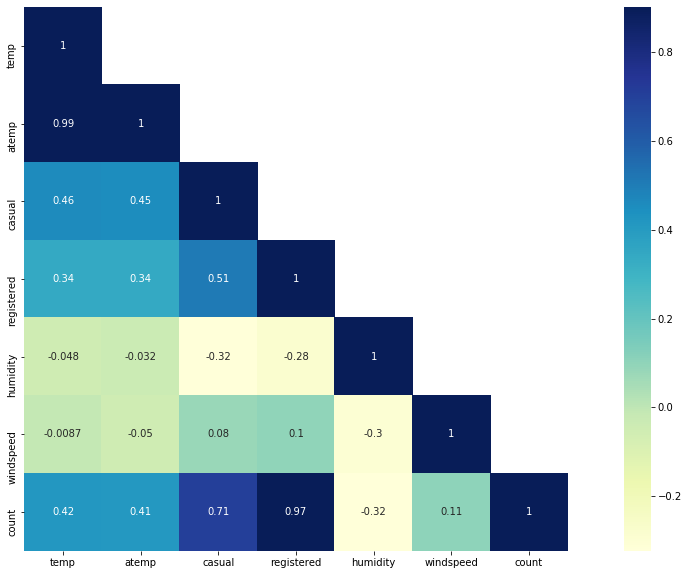

In [49]:
# looking at the correlation between numerical variables
corr = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr, mask=mask,vmax=.9, square=True,annot=True, cmap="YlGnBu")

Before building the model, let's check if there are any missing values in the dataset.

In [50]:
# looking for missing values in the datasaet
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

There are no missing values in the train dataset. Let's look for the missing values in the test dataset.

In [51]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
dtype: int64

There are no missing values in the test dataset as well. I can now move further and build our first model. Before that let me first extract some new features using the datetime variable. I can extract the date, hour, month.

In [52]:
# extracting date, hour and month from the datetime
train["date"] = train.datetime.apply(lambda x : x.split()[0])
train["hour"] = train.datetime.apply(lambda x : x.split()[1].split(":")[0])
train["month"] = train.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [53]:
test["date"] = test.datetime.apply(lambda x : x.split()[0])
test["hour"] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])
test["month"] = test.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

Now the data is ready. Before making the model, I will create a validation set to validate our model. So, I will divide the train set into training and validation set. I will train the model on the training set and check its performance on the validation set. Since the data is time based, I will split it as per time. Let's take first 15 months for training and remaining 3 months in the validation set. 

In [54]:
training = train[train['datetime']<='2012-03-30 0:00:00']
validation = train[train['datetime']>'2012-03-30 0:00:00']

* I will drop the datetime, date variable as I have already extracted features from these variables.
* I will also drop the atemp variable as I saw that it is highly correlated with the temp variable.

In [55]:
train = train.drop(['datetime','date', 'atemp'],axis=1)
test = test.drop(['datetime','date', 'atemp'], axis=1)
training = training.drop(['datetime','date', 'atemp'],axis=1)
validation = validation.drop(['datetime','date', 'atemp'],axis=1)

## Model Building
### Linear Regression Model

In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
# initialize the linear regression model
lModel = LinearRegression()

I will remove the target variable from both the training and validation set and keep it in a separate variable. To make it less skewed, I will take the log values.

In [58]:
X_train = training.drop('count', 1)
y_train = np.log(training['count'])
X_val = validation.drop('count', 1)
y_val = np.log(validation['count'])

In [59]:
# checking the shape of X_train, y_train, X_val and y_val
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10774, 11), (10774,), (2206, 11), (2206,))

In [60]:
# fitting the model on X_train and y_train
lModel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now I have a trained linear regression model with me. I will now make prediction on the X_val set and check the performance of our model. Since the evaluation metric for this problem is RMSLE, I will define a model which will return the RMSLE score.

In [61]:
# making prediction on validation set
prediction = lModel.predict(X_val)

In [62]:
# defining a function which will return the rmsle score
def rmsle(y, y_):
    y = np.exp(y),   # taking the exponential as we took the log of target variable
    y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

Let's now calculate the rmsle value of the predictions

In [63]:
rmsle(y_val,prediction)

0.8875379204281797

In [64]:
test_prediction = lModel.predict(test)

Got a rmsle value of 0.8875 on the validation set.

Let's use Decision Tree now to further reduce the rmsle value to see the reduce the overfitting or underfitting.

## Decision Tree

In [65]:
from sklearn.tree import DecisionTreeRegressor

In [66]:
# defining a decision tree model with a depth of 5. You can further tune the hyperparameters to improve the score
dt_reg = DecisionTreeRegressor(max_depth=5)

Let's fit the decision tree model now.

In [67]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Its time to make prediction on the validation set using the trained decision tree model.

In [68]:
predict = dt_reg.predict(X_val)

In [69]:
# calculating rmsle of the predicted values
rmsle(y_val, predict)

0.17102267399447005

The rmsle value has decreased to 0.171. This is a decent score. 
Let's now make predictions for the test dataset which now I can submit in the excel sheet to generate score. (Final Output)

In [70]:
test_prediction = dt_reg.predict(test)

Since I took the log values, now I have to reduce tem to original value to gain the correct result.

In [71]:
final_prediction = np.exp(test_prediction)

Finally, I will save these predictions into a csv file. I can then open this csv file and copy paste the predictions on the provided excel file to generate score.

In [72]:
submission = pd.DataFrame()

In [73]:
# creating a count column and saving the predictions in it
submission['count'] = final_prediction

In [74]:
submission.to_csv('submission.csv', header=True, index=False)

Now I have generated the submission file. To generate score (Final Output) :
1. Open the submission.csv file.
2. Copy the values in the subscribed column and paste them in the subscribed column of solution_checker.xlsx file.
3. We can see the accuracy of the model on test dataset under accuracy score column.